This is the training script for our best performing models (pre-trained ResNet by PyTorch)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import random
import os
import csv

from Config import Config
from Models import PreTrainedKPD, Tools

/Users/julienstal/Library/Python/3.9/lib/python/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def split_data(data, test_size=0.15, random_seed=None):
    """
    Split dataset into train and test datasets. In our case, datasets are lists of dictionaries which
    contain entries: "Image Name", "x1", "y1", "x2", "y2"
    
    Parameters:
        data (list of dict): The input data to be split.
        test_size (float): Proportion of the dataset to include in the test split (default is 0.2).
        random_seed (int, optional): Random seed for reproducibility (default is None).
    
    Returns:
        tuple: (train_data, test_data) where both are lists of dictionaries.
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    # Shuffle the data
    shuffled_data = data[:]
    random.shuffle(shuffled_data)
    
    # Compute the split index
    split_idx = int(len(shuffled_data) * (1 - test_size))
    
    # Split the data
    train_data = shuffled_data[:split_idx]
    test_data = shuffled_data[split_idx:]
    
    return train_data, test_data

In [4]:
"""
Create datasets by reading the csv files that contain the coordinates.
"""
with open(Config.coords_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

train_data, test_data = split_data(data)
print(f"{len(train_data)} training points and {len(test_data)} test points.")

3262 training points and 576 test points.


In [5]:
# MPS is the CUDA (GPU) equivalent on Macs for much faster training.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: mps


In [ ]:
"""
Create and train keypoint detection model. 
The KeypointDetection Model (KPD) takes images as inputs and learns to find the two points defining Weber's length.
Note: we keep track and restore the best performing version on the test dataset to avoid overfitting

The model was pretrained on general images and we modified it for keypoint detection. Here we start by introducing it to
the specific demands of our problem by training it on AUGMENTED images which will still allow some room for some finetuning
with non-augmented images later.
"""
kpd_model = PreTrainedKPD.KeypointDetectionModel().to(device)
Tools.train_kpd_model(kpd_model, train_data, test_data, 50, 401, feedback_rate=50, initial_lr=1e-4, augment_training_images=True, plot_progression=True)

In [8]:
best_state = kpd_model.state_dict()

Epoch 0: test loss = 0.006222343537956476, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.002509327605366707, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.0021215537562966347, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.0021841705311089754, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.00191624672152102, lr = 1.326398781093821e-05
Epoch 250: test loss = 0.0018023608718067408, lr = 8.024793100055947e-06
Epoch 300: test loss = 0.001749277114868164, lr = 4.855048513057286e-06
Epoch 350: test loss = 0.0017230871599167585, lr = 2.9373338066467324e-06
Epoch 400: test loss = 0.0017023463733494282, lr = 1.7771047742294685e-06
Epoch 450: test loss = 0.0017089592292904854, lr = 1.0751591703479103e-06
Epoch 500: test loss = 0.0016943534137681127, lr = 6.50477821199046e-07
Training complete, reverting to best model state


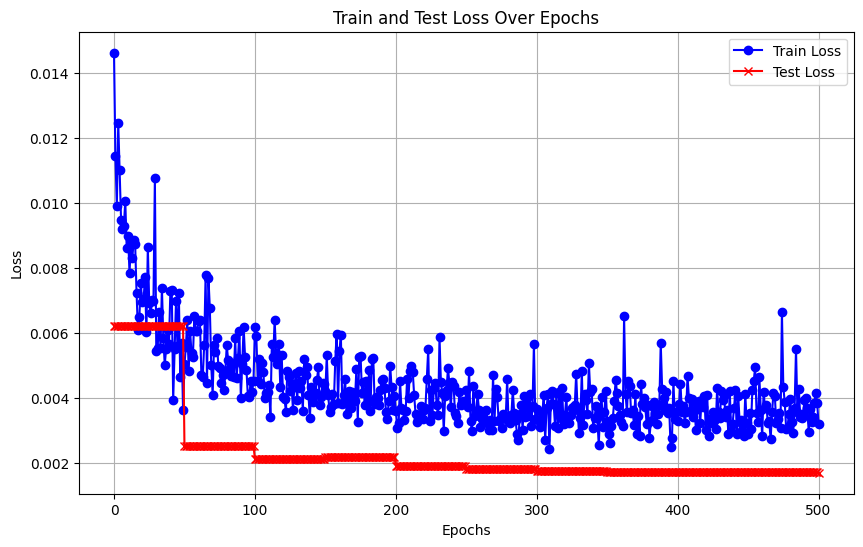

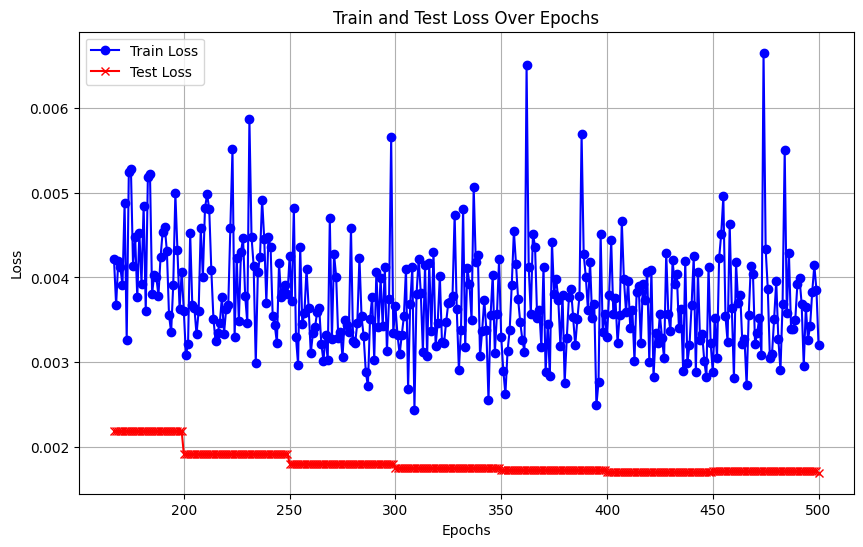

In [9]:
"""
We now fine-tune our model to the specific demands of the problem, where the ant images are well defined and ants are always in the same position.
=> No longer augment the images !
"""
Tools.train_kpd_model(kpd_model, train_data, test_data, 50, 501, feedback_rate=50, initial_lr=1e-4, augment_training_images=False, plot_progression=True)

In [ ]:
"""
Depending on how the convergence looked in the last cell, it can be useful to perform some more training iterations
"""

#Tools.train_kpd_model(kpd_model, train_data, test_data, 50, 201, feedback_rate=25, initial_lr=5*(1e-6), augment_training_images=False, plot_progression=True)

In [18]:
# Save weights (RAM)
best_kpd_state = kpd_model.state_dict()

In [80]:
kpd_model.load_state_dict(best_kpd_state)
kpd_model = kpd_model.to(device)

In [66]:
# Save weights (Disc)
torch.save(kpd_model.state_dict(), "pretrainedKPD_weights00166.pth")
torch.save(kpd_model, "pretrainedKPD_fullModel00166.pth")

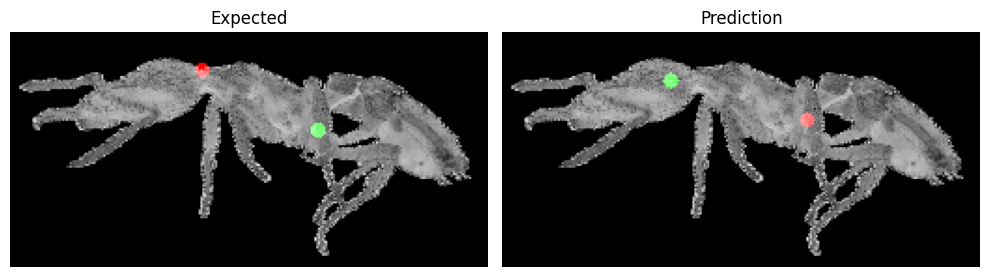

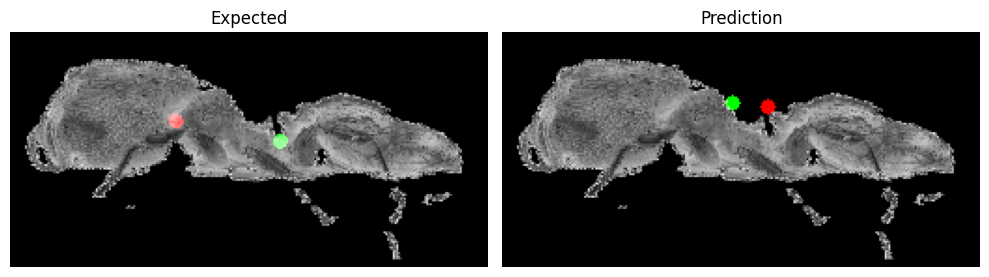

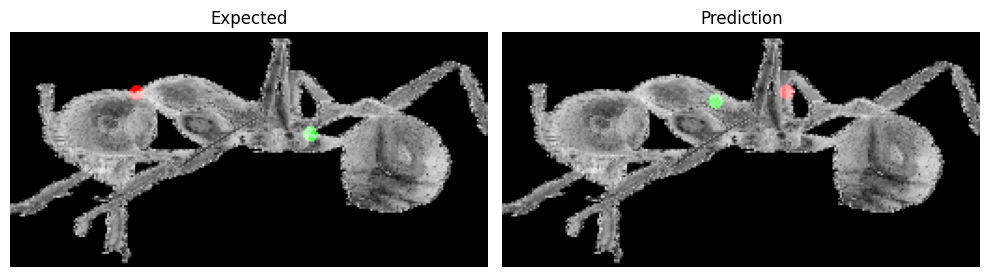

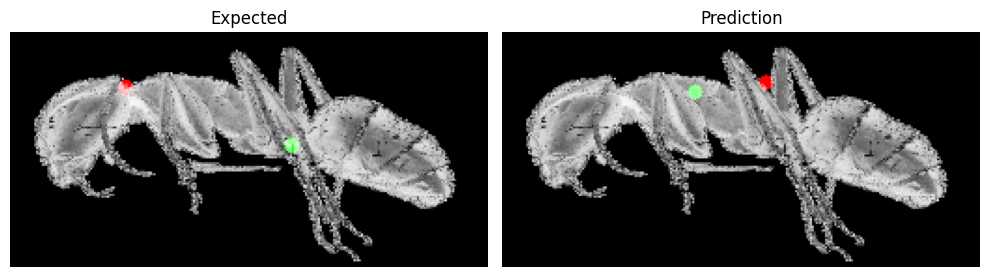

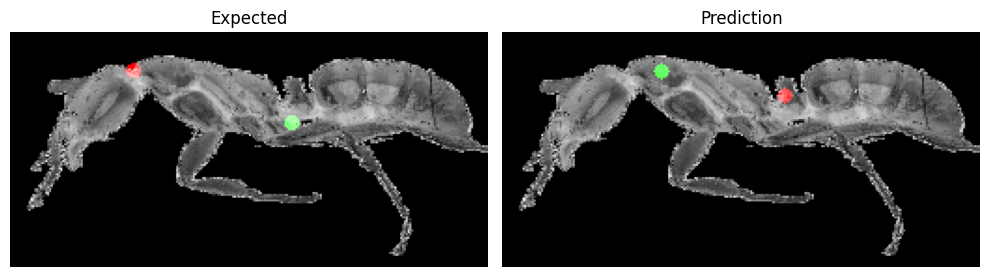

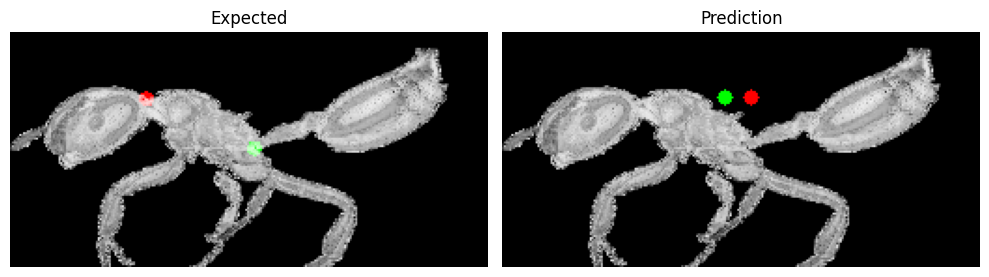

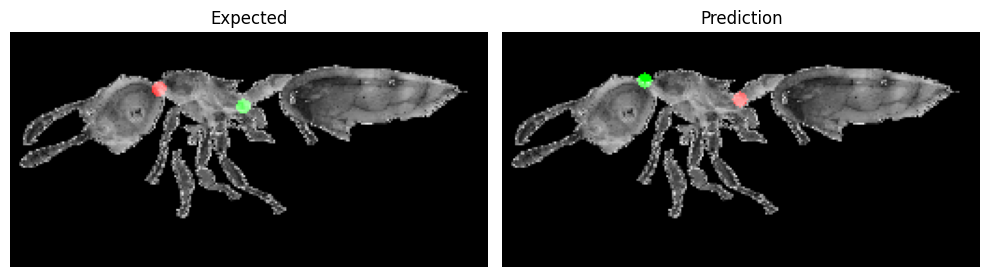

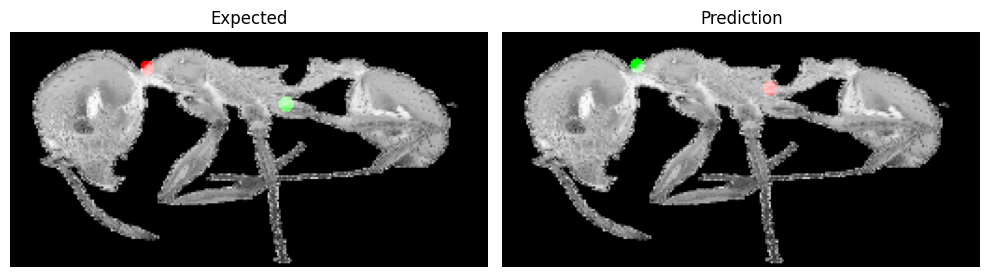

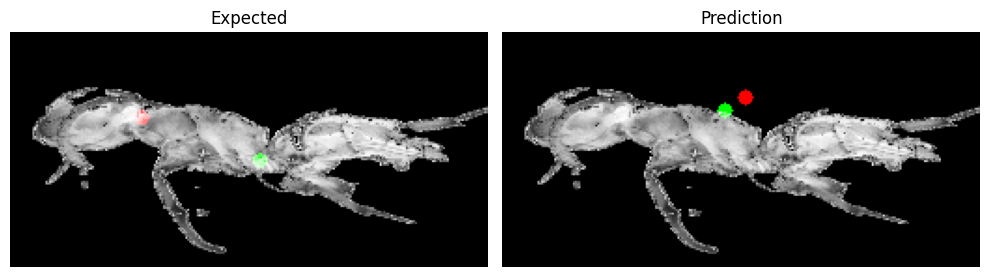

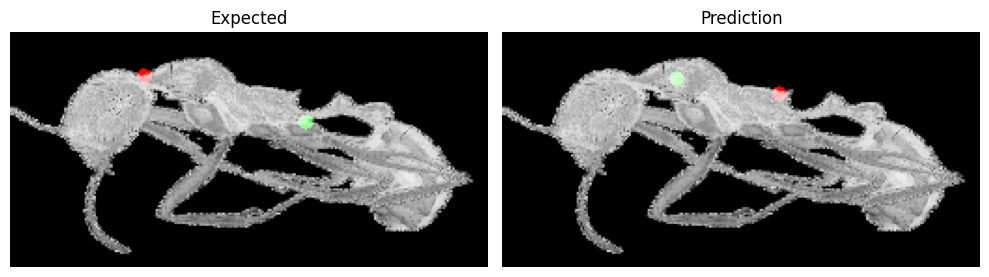

In [81]:
kpd_model.eval()

# Check predictions
Tools.plot_model_prediction(kpd_model, test_data, 10, conf_model = None, error_estimation_interval= [-1, 1], augment_images=False, device="mps")

Building error data for confidence model
Before clamp


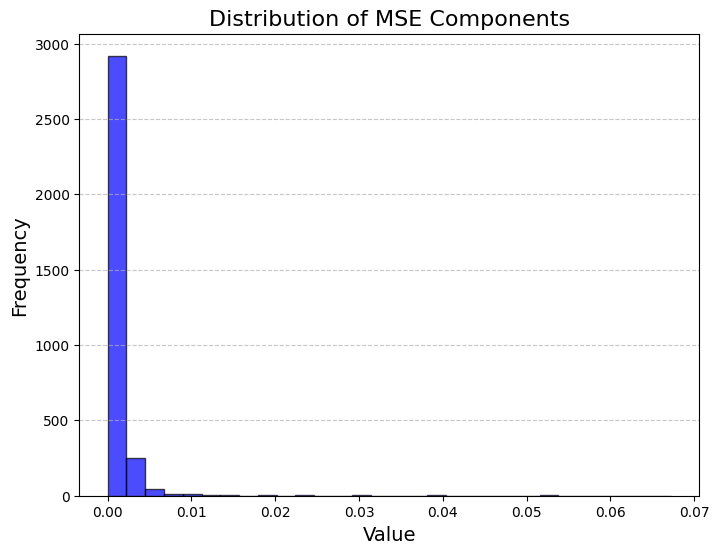

After clipping


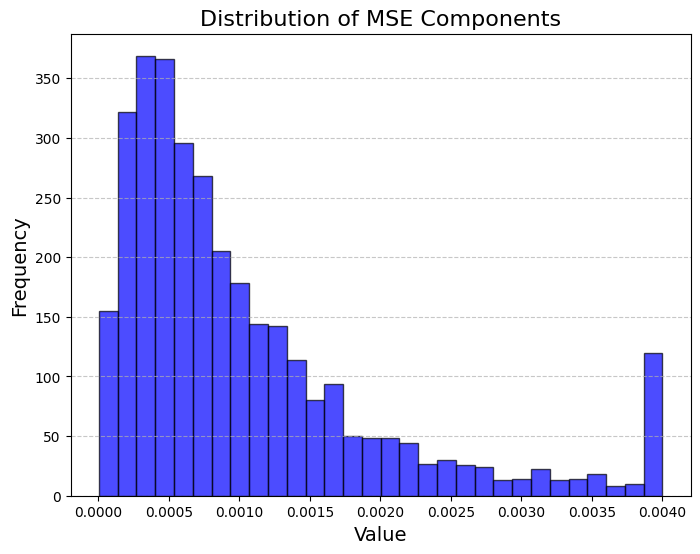

Normalized


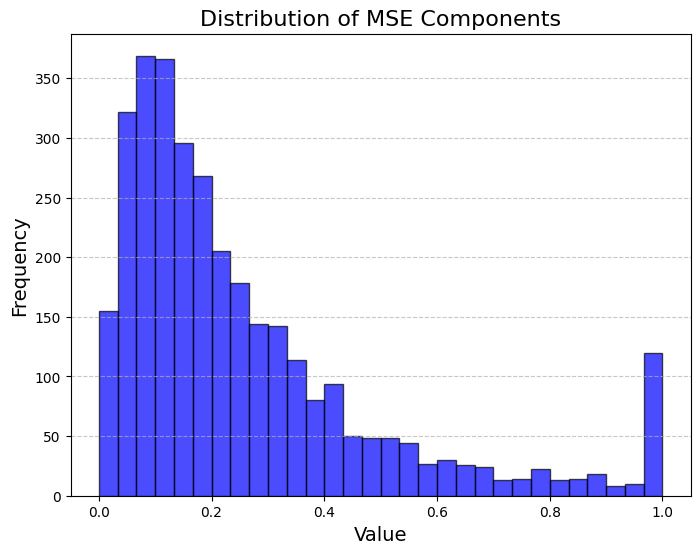

Building error data for confidence model
Before clamp


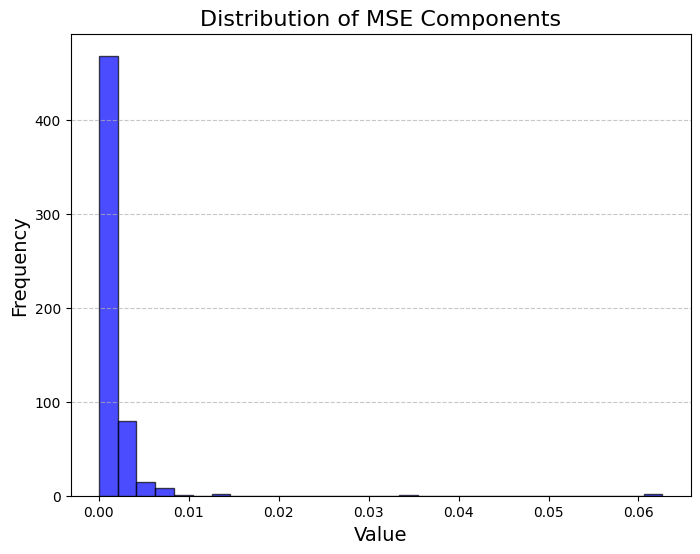

After clipping


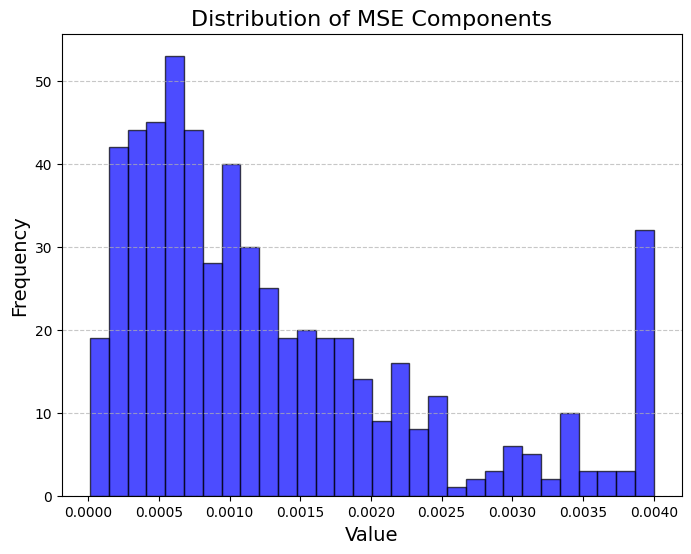

Normalized


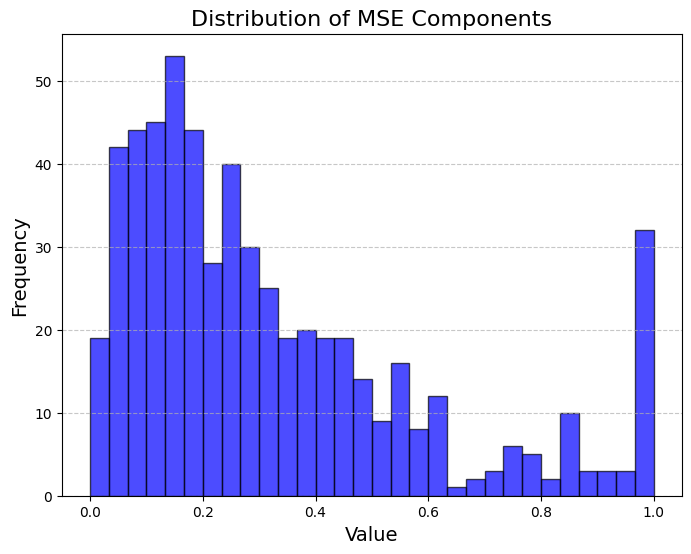

In [55]:
# Now train the confidence model !

from Models import PreTrainedConf
kpd_model.eval()

conf_model = PreTrainedConf.ConfidenceModel().to(device)

"""
Create error data by running the KPD model on the dataset and computing the errors.
!! WARNING !! It's far from ideal to use the same train set and test set as for the KPD model training because
it will naturally perform better on the train set so the train error data will be slightly biased (downwards), but we
don't have enough data to do otherwise.

The errors for each images are computed, clamped to a specific range to get rid of outliers and then normalized, 
so that the probability distribution of the errors is somewhat usable.
"""
train_error_data, norm_min, norm_max = Tools.build_error_data(kpd_model, train_data)
test_error_data, _, __ = Tools.build_error_data(kpd_model, test_data)

In [57]:
"""
Training the confidence model in the same way as the KPD model.
Note how it converges very quickly which implies that things are still far from perfect.
First, train it on augmented images.
"""
Tools.train_conf_model_fast(conf_model, train_error_data, test_error_data, 50, len(test_error_data), 101, initial_lr=1e-4, lr_decay=0.99, device="mps", augment_training_images=True, feedback_rate=25, normalize_errors=False)

Epoch 0: test loss = 0.20317265391349792, lr = 9.900000000000001e-05
Epoch 25: test loss = 0.11060401052236557, lr = 7.700431458051554e-05
Epoch 50: test loss = 0.07675988227128983, lr = 5.9895600646616125e-05
Epoch 75: test loss = 0.08881277590990067, lr = 4.658807751697937e-05
Epoch 100: test loss = 0.0744594931602478, lr = 3.62372017860497e-05


In [41]:
best_conf_model_state = conf_model.state_dict()

In [58]:
"""
Finetune it on specific non-augmented images.
"""
Tools.train_conf_model_fast(conf_model, train_error_data, test_error_data, 50, len(test_error_data), 201, initial_lr=1e-4, lr_decay=0.99, device="mps", augment_training_images=False, feedback_rate=50, normalize_errors=False)

Epoch 0: test loss = 0.08780322223901749, lr = 9.900000000000001e-05
Epoch 50: test loss = 0.0719362273812294, lr = 5.9895600646616125e-05
Epoch 100: test loss = 0.06938014179468155, lr = 3.62372017860497e-05
Epoch 150: test loss = 0.06959427893161774, lr = 2.1923726936647233e-05
Epoch 200: test loss = 0.07040883600711823, lr = 1.326398781093821e-05


Confident predictions:
Error estimation =  0.0935918539762497


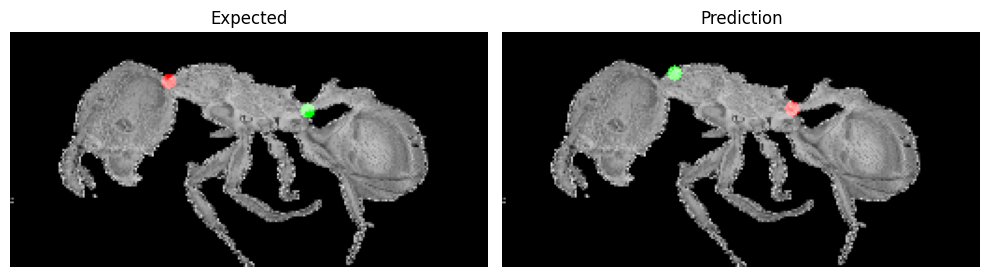

Error estimation =  0.06994101405143738


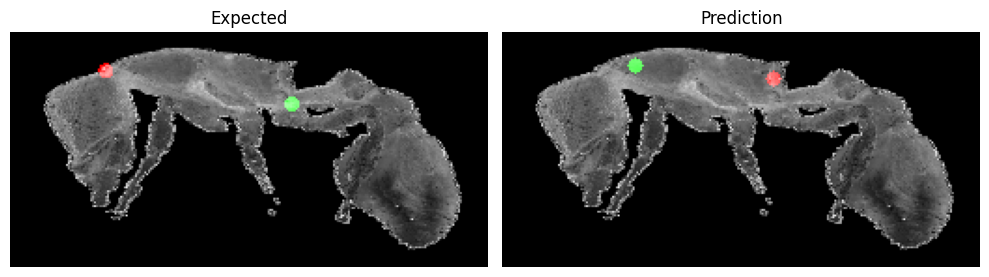

Error estimation =  -0.06148053705692291


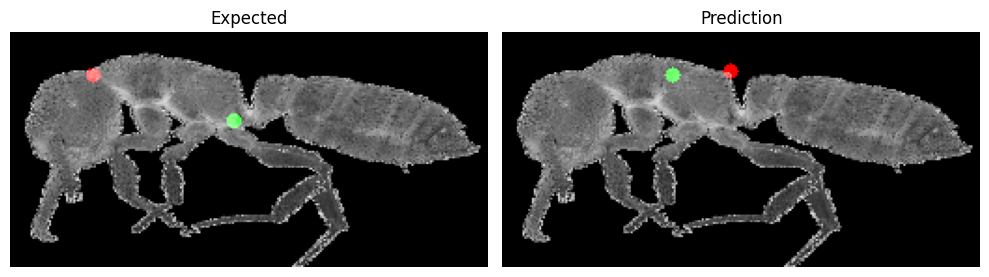

Error estimation =  0.07998022437095642


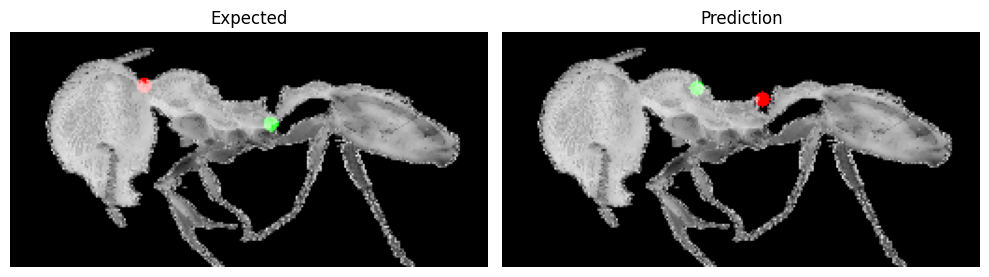

Error estimation =  0.0893443301320076


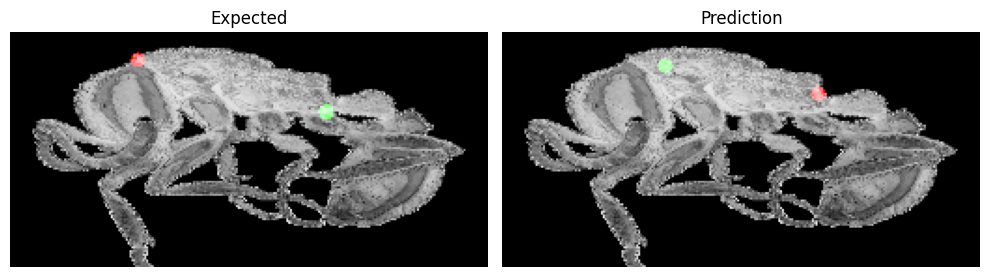

Error estimation =  0.06865245848894119


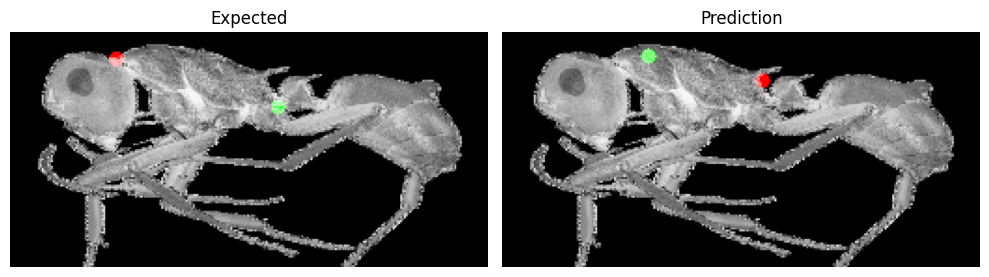

Error estimation =  0.0910177007317543


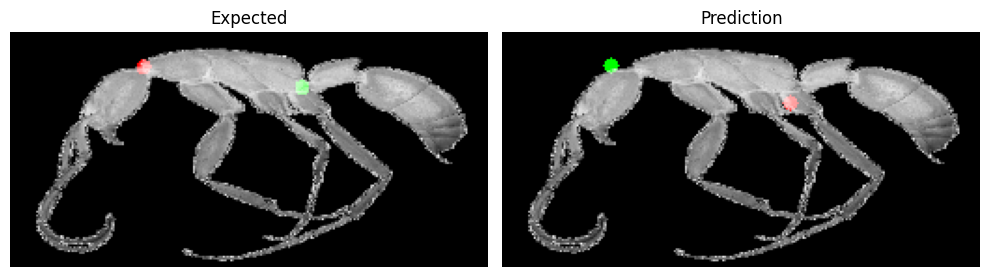

Error estimation =  0.06717681139707565


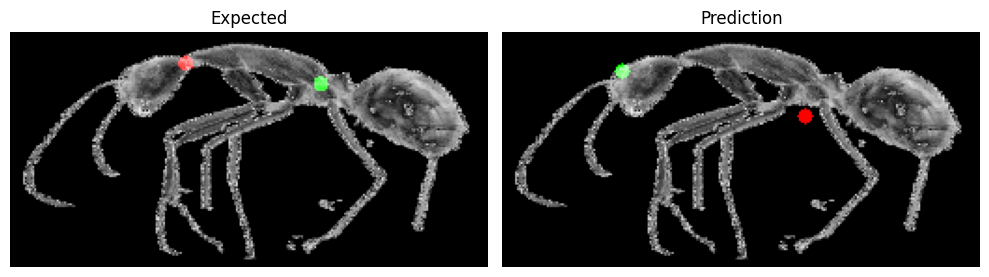

Error estimation =  0.08469931781291962


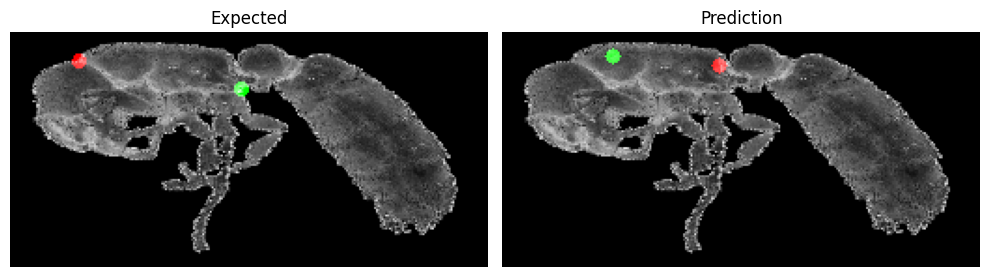

Error estimation =  0.057268332690000534


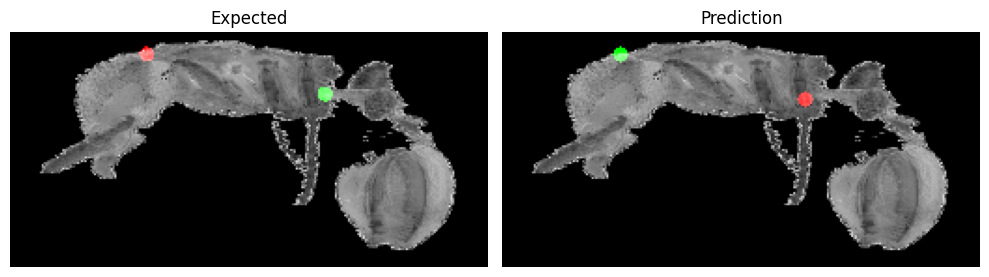

Error estimation =  0.0925101488828659


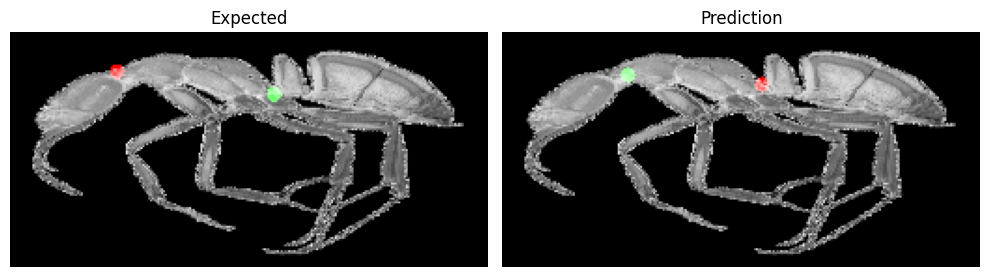

Error estimation =  0.060613151639699936


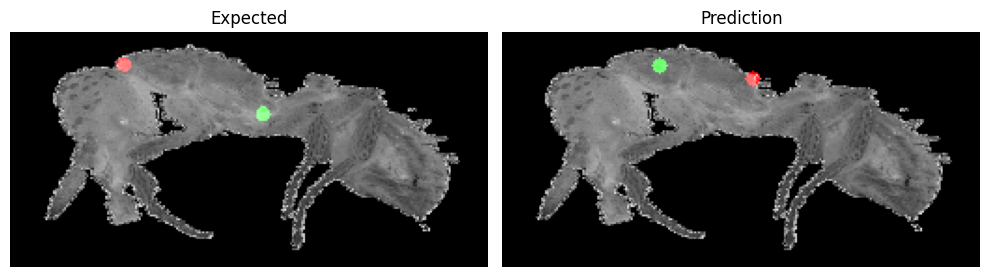

Error estimation =  0.06570244580507278


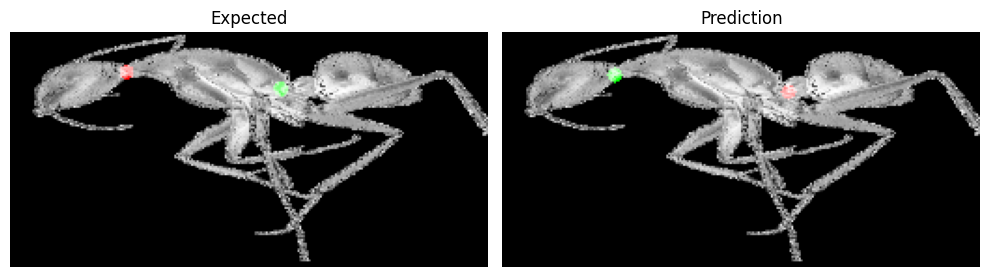

Error estimation =  0.08380765467882156


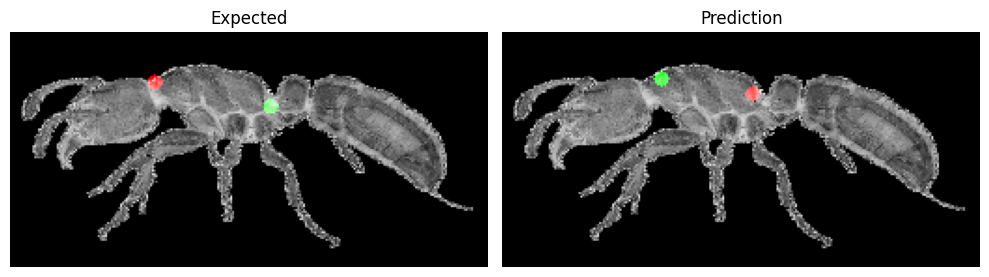

Error estimation =  0.06055231764912605


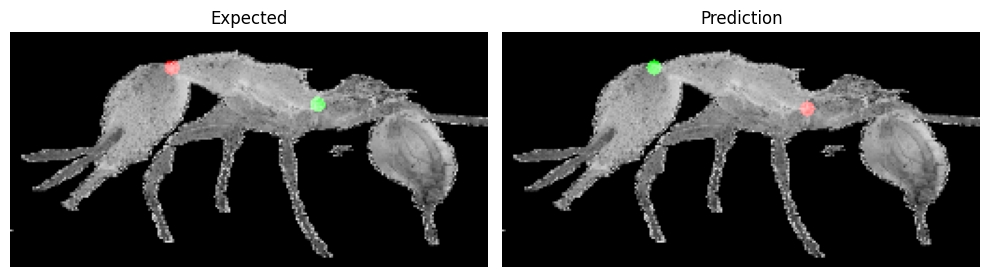

Error estimation =  0.08601470291614532


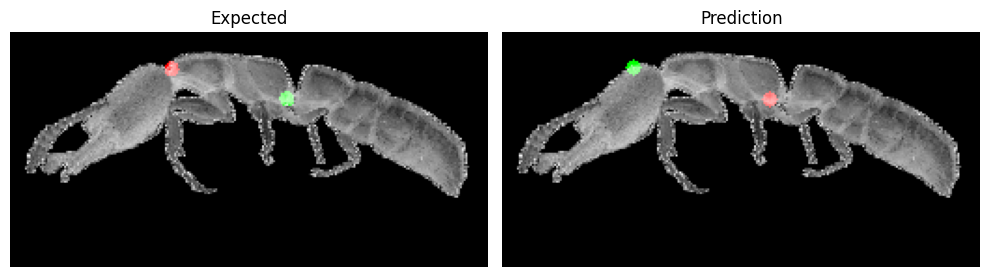

In [63]:
print("Confident predictions:")
Tools.plot_model_prediction(kpd_model, train_data, 80, conf_model=conf_model, error_estimation_interval=[-1, 0.1])

Low-confidence predictions
Error estimation =  0.6908707618713379


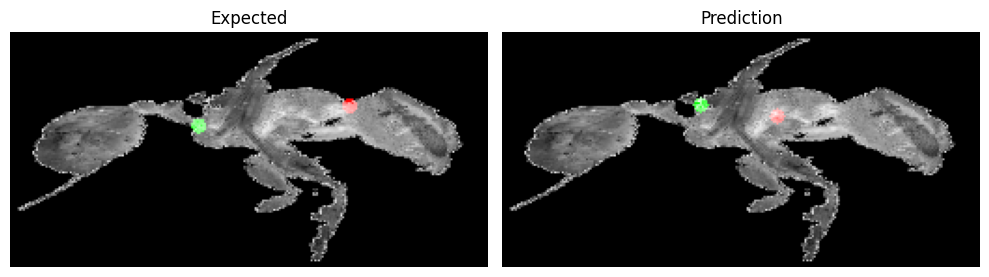

Error estimation =  0.8285723328590393


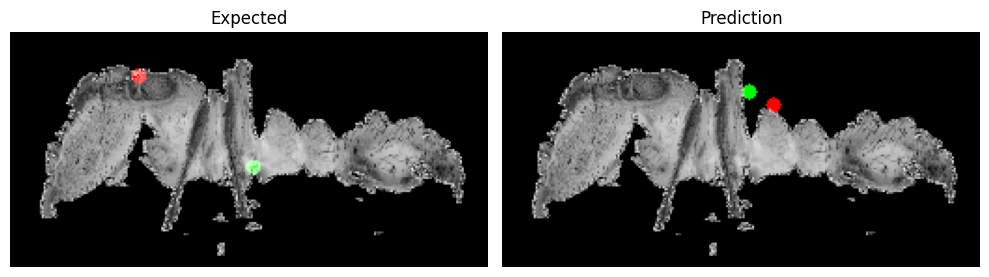

Error estimation =  0.6365639567375183


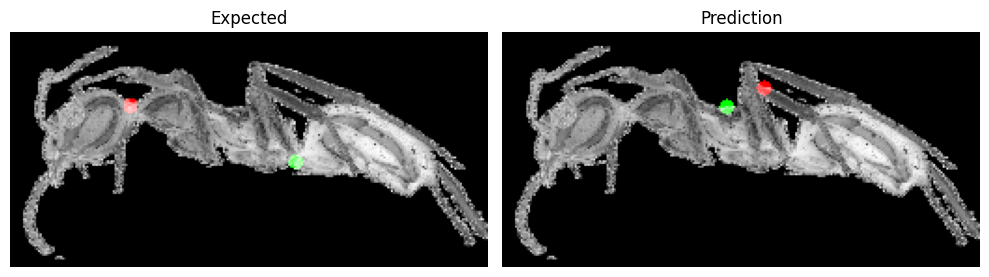

Error estimation =  0.4868919551372528


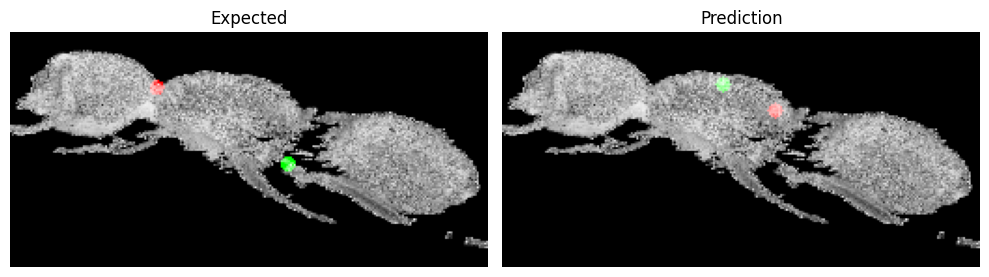

Error estimation =  0.478257954120636


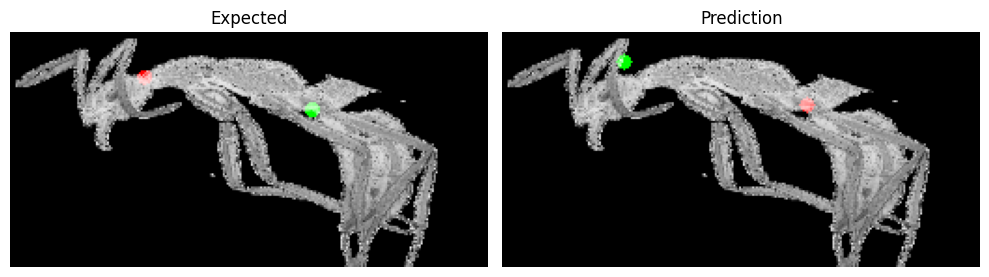

Error estimation =  0.5073296427726746


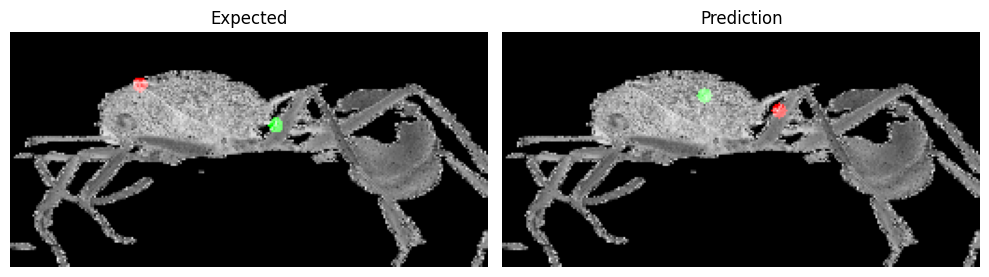

Error estimation =  0.4221678376197815


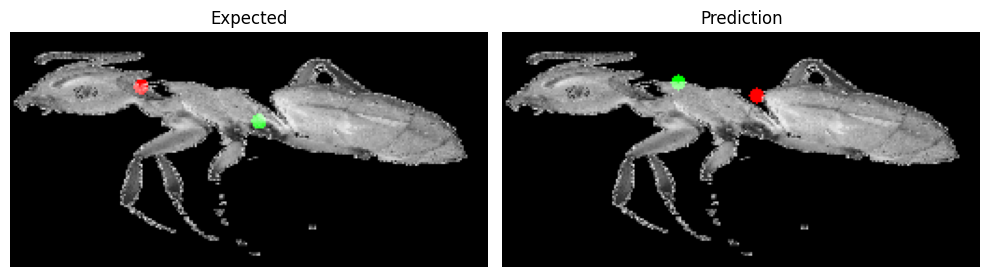

In [65]:
print("Low-confidence predictions")
Tools.plot_model_prediction(kpd_model, train_data, 80, conf_model=conf_model, error_estimation_interval=[0.4, 1])

In [67]:
torch.save(conf_model.state_dict(), "pretrainedConf_weights00166.pth")
torch.save(conf_model, "pretrainedConf_fullModel00166.pth")